# Requirement Installation

In [0]:
!pip install PyDrive
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install Augmentor

#**Imports Section**

---



In [0]:
import os, random, shutil, math
from collections import Counter
import Augmentor
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.utils import shuffle


from keras.layers import GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
import keras
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import applications

In [0]:
from tensorflow.python.client import device_lib
from google.colab import drive

# Basic Setup


---



In [0]:
#@title
device_lib.list_local_devices()
drive.mount('/content/gdrive')

base_dir = '/content/gdrive/My Drive/Datasets/orignal'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Processing Functions


---



In [0]:
"""
Description:=> This function shuffles the data and labels by zipping them together
Parameters:=> Two
1) "data" || array of data(images (256,256,3))
2) "label" || array of label (depends upon classes)
"""

def shuffle_data(data, label):
    data = np.array(data, dtype=float)
    label = np.array(label, dtype=int)
    data, label = shuffle(data, label)
    return data, label

In [0]:
""" 
Description:=> This function count files in the directory
Parameters:=> One
1) "folder_path" || path of the directory, you want to count files of
"""

def total_files(folder_path=""):
    dirs = os.walk(folder_path)
    files_count =0
    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        dir_name = os.path.basename(dir_path)

        print(f'{dir_name}: {len(dir_files)}')
        files_count = files_count + len(dir_files)
    print(f"Total Filess:= {files_count}")
    return int(files_count)

In [0]:
"""
Description:=> You give this folder path, it will return array of data and labels in shuffeled form
Parameters:=> Three
1) "folder_path" || path of directory, from where you want to read images
2) "img_h" || height of images if you want to adjust them (default is 128)
3) "img_w" || height of images if you want to adjust them (default is 128)
"""

def get_data(folder_path="", img_h=128, img_w=128):
    dirs = os.walk(folder_path)

    master_data = []
    master_labels = []
    image_sizes = []
    none_data = 0

    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        dir_name = os.path.basename(dir_path)
        for file in dir_files:
            file_path = os.path.join(dir_path, file)

            image = cv.imread(file_path)
            i_height = np.size(image, 0)
            i_width = np.size(image, 1)

            image_sizes.append([i_height, i_width])

            # file_data = np.array(cv.imread(file_path, cv.IMREAD_GRAYSCALE))
            file_data = np.array(cv.imread(file_path))

            if (file_data.any() != None):
                
                if (i_height != img_h or i_width != img_w):
                    file_data = cv.resize(file_data, dsize=(img_h, img_w), interpolation=cv.INTER_LANCZOS4)
                    
                # Image Shape: Height x Width x Depth(RGB)
                reshaped_data = file_data.reshape((file_data.shape[0]), (file_data.shape[1]), 3)
                master_data.append(reshaped_data)
                master_labels.append(np.array([dir_name]))
                # master_labels.append(np.array([((int(os.path.basename(dir_path)))-1)]))
            else:
                print(file_path)
                none_data += 1
        print(f'Directory:=> {dir_path}')
        
    print(f'Total Images: {len(master_data)} || Total Labels: {len(master_labels)} || Total Errors: {none_data}')
    return shuffle_data(master_data, master_labels)


# Augmentation Functions

---



In [0]:
def orignal_to_train_test():
  dbase_dir = '/content/gdrive/My Drive/Datasets/orignal'
  train_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
  test_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'

  dirs = os.walk(dbase_dir)
  for s_dir in dirs:
      dir_path = s_dir[0]
      dir_files = s_dir[2]

      if (dir_files != 0):
          dir_name = os.path.basename(dir_path)

          test_files = random.sample(dir_files, int(0.2 * len(dir_files)))
          train_files = list(set(dir_files) - set(test_files))

          print(f'Directory: {dir_name} || Test Files: {len(test_files)} || Train Files: {len(train_files)}')

          os.mkdir(os.path.join(test_dir, str(dir_name)))
          os.mkdir(os.path.join(train_dir, str(dir_name)))

          current_test_dir = os.path.join(test_dir, str(dir_name))
          current_train_dir = os.path.join(train_dir, str(dir_name))

          for fname in test_files:
              srcpath = os.path.join(dir_path, fname)
              shutil.copy(srcpath, current_test_dir)

          for fname in train_files:
              srcpath = os.path.join(dir_path, fname)
              shutil.copy(srcpath, current_train_dir)


In [0]:
def do_augmentation(input_dir="", output_dir="", max_files=0, max_folder=""):
    dirs = os.walk(input_dir)
    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        dir_name = os.path.basename(dir_path)

        print(f'Inside Folder: {dir_path}')
        print(f'Total Files: {len(dir_files)}')

        if(len(dir_files) != 0):
          if(dir_name != max_folder):
              new_dataset = os.path.join(output_dir, dir_name)
              p = Augmentor.Pipeline(source_directory=dir_path, output_directory=new_dataset)
              p.flip_left_right(probability=1)
              p.flip_top_bottom(probability=0.85)
              p.rotate(probability=0.90, max_left_rotation=25, max_right_rotation=25)
              p.zoom_random(probability=0.25, percentage_area=0.35)
              p.crop_centre(probability=0.85, percentage_area=0.75)
              p.crop_random(probability=0.75, percentage_area=0.65)
              #p.resize(probability=1.0, width=256, height=256)
              p.sample(int((max_files / (len(dir_files))) * (len(dir_files))))
          else:
              os.mkdir(os.path.join(output_dir, str(dir_name)))
              outpath = os.path.join(output_dir, dir_name)
              for fname in dir_files:
                srcpath = os.path.join(dir_path, fname)
                shutil.copy(srcpath, outpath)

    return "All Gone Well"


In [0]:
def read_image(img_path="", img_h=128, img_w=128):
    image = cv.imread(img_path)
    i_height = np.size(image, 0)
    i_width = np.size(image, 1)

    file_data = np.array(cv.imread(img_path))

    if (file_data.any() != None):
        if (i_height != img_h or i_width != img_w):
            file_data = cv.resize(file_data, dsize=(img_h, img_w), interpolation=cv.INTER_LANCZOS4)

        file_data = file_data.reshape((file_data.shape[0]), (file_data.shape[1]), 3)
        return file_data
    else:
        return None


def data_generator(folder_path="", img_h=128, img_w=128, batch_size=128):
    dirs = os.walk(folder_path)

    paths_labels = []

    for s_dir in dirs:
        dir_path = s_dir[0]
        dir_files = s_dir[2]
        for file in dir_files:
            single_image_path = os.path.join(dir_path, file)
            single_image_label = os.path.basename(dir_path)
            paths_labels.append([single_image_path, single_image_label])

    random.shuffle(paths_labels)
    tdata_len = len(paths_labels)
    iterations = math.ceil(tdata_len / batch_size)

    for count in range(iterations):
        m_data = []
        m_label = []

        if ((count + 1) * batch_size < tdata_len):
            to_loop = paths_labels[count * batch_size:(count + 1) * batch_size]
            for img in to_loop:
                m_data.append(read_image(img[0], img_h, img_w))
                m_label.append([int(img[1])-1])
            yield np.array(m_data, dtype=float), np.array(m_label)
        else:
            to_loop = paths_labels[count * batch_size:]
            for img in to_loop:
                m_data.append(read_image(img[0], img_h, img_w))
                m_label.append([int(img[1])-1])
                yield np.array(m_data, dtype=float), np.array(m_label)


**Augmentation Intialization Code**

**WARNING**: *Before Calling Check The Folder Structure, Because This Is Not Creating New Directories But Generating in The Old Ones*

In [0]:
#This call will split the 20% data randomly in the folders mentioned in the function.
orignal_to_train_test()

Directory: orignal || Test Files: 0 || Train Files: 0
Directory: 7 || Test Files: 11 || Train Files: 47
Directory: 1 || Test Files: 23 || Train Files: 93
Directory: 4 || Test Files: 15 || Train Files: 63
Directory: 2 || Test Files: 21 || Train Files: 84
Directory: 3 || Test Files: 14 || Train Files: 58
Directory: 5 || Test Files: 11 || Train Files: 45
Directory: 6 || Test Files: 375 || Train Files: 1504


In [0]:
# This is augmentation of data, according to the definition given in the function.

train_aug_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train_aug'
test_aug_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test_aug'

train_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
test_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'


#a = do_augmentation(test_dir, test_aug_dir, 376, '6')
#print(f'Test Data Augmentation: {a}')

#b = do_augmentation(train_dir, train_aug_dir, 1504, '6')
#print(f'Test Data Augmentation: {b}')

In [0]:
total_files('/content/gdrive/My Drive/Datasets/tt_dataset/train_aug')

train_aug: 0
7: 1504
1: 1504
4: 1504
2: 1504
3: 1504
5: 1504
6: 1504
Total Filess:= 10528


10528

In [0]:
#Total Files Count Checking

# Model Helper Functions

In [0]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    y = np.ravel(y)
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

In [0]:
#Balance Test Batch Generation
def get_balance_random_test(folder_path="", img_h=300, img_w=300, batch_size=70, num_of_classes=7, test=50):
  dirs = os.walk(folder_path)
  
  samples = int(batch_size/num_of_classes)
  
  
  
  for num in range(test):
    m_data = []
    m_label = []
    dirs = os.walk(folder_path)
    
    for s_dir in dirs:
          dir_path = s_dir[0]
          dir_files = s_dir[2]
          dir_name = os.path.basename(dir_path)

          if(len(dir_files) > 0):
            tfiles = random.sample(dir_files, samples)
            for file in tfiles:
              single_image_path = os.path.join(dir_path, file)
              single_image_label = dir_name
              m_data.append(read_image(single_image_path, img_h, img_w))
              m_label.append([int(dir_name)-1])
    yield shuffle_data(m_data, m_label)
  


---

# TRANSFER LEARNING

---

In [0]:
img_width = 224
img_height = 224
num_of_classes = 7

batch_size = 21
epochs = 75

In [0]:


train_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/train'
test_dir = '/content/gdrive/My Drive/Datasets/tt_dataset/test'

total_files(test_dir)
orignal_dir = '/content/gdrive/My Drive/Datasets/orignal'

#train_data, train_labels = get_data(train_dir, img_height, img_width)
#train_data, train_labels = get_data(orignal_dir, img_height, img_width)

train_generator = get_balance_random_test(folder_path=train_dir, img_h=img_height, img_w=img_width, batch_size=70, num_of_classes=7, test=1000)
test_generator = get_balance_random_test(folder_path=test_dir, img_h=img_height, img_w=img_width, batch_size=70, num_of_classes=7, test=1000)

test: 0
orignal: 0
7: 11
1: 23
4: 15
2: 21
3: 14
5: 11
6: 375
Total Filess:= 470


In [0]:
#class_weights = get_class_weights(train_labels-1)

model = applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

model.summary()

for layer in model.layers[:-10]:
    layer.trainable = False

# Adding custom Layers
x = model.output
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
predictions = Dense(num_of_classes, activation="softmax")(x)

# creating the final model
model_final = Model(input=model.input, output=predictions)

model_final.summary()


model_final.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
train_acc = []
train_err = []

test_acc= []
test_err = []

for i in range(epochs):
  test_d, test_l = next(test_generator)
  train_d, train_l = next(train_generator)
  
  train_result = model_final.train_on_batch(train_d, train_l)
  test_result = model_final.test_on_batch(test_d, test_l)
  
  test_acc.append(test_result[1])
  test_err.append(test_result[0])
  
  train_acc.append(train_result[1])
  train_err.append(train_result[0])
  
  print(f'Training | Test LOSS: {train_result[0]} | {test_result[0]}')
  print(f'Training | Test ACCURACY: {train_result[1]} | {test_result[1]}')
  print(f'++============================================================++')


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
res2b_branch2b (Conv2D)         (None, 56, 56, 64)   36928       activation_103[0][0]             
__________________________________________________________________________________________________
bn2b_branch2b (BatchNormalizati (None, 56, 56, 64)   256         res2b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_104 (Activation)     (None, 56, 56, 64)   0           bn2b_branch2b[0][0]              
__________________________________________________________________________________________________
res2b_branch2c (Conv2D)         (None, 56, 56, 256)  16640       activation_104[0][0]             
__________________________________________________________________________________________________
bn2b_branch2c (BatchNormalizati (None, 56, 56, 256)  1024        res2b_branch2c[0][0]             
__________

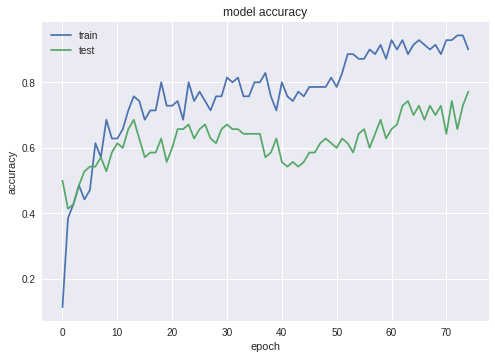

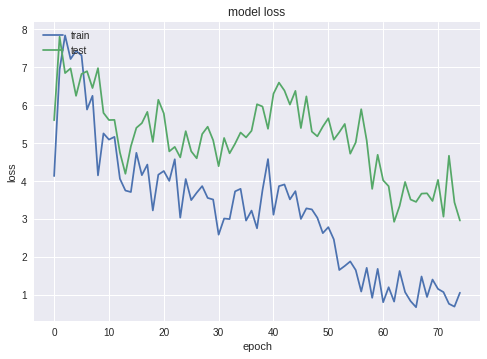

In [0]:
# summarize history for accuracy
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_err)
plt.plot(test_err)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
acc = []
err = []
a=get_balance_random_test(test_dir,224,224,test=100)
for test_d, test_l in a:
  result = model_final.test_on_batch(test_d,test_l)
  acc.append(result[1])
  err.append(result[0])
  print(f'Sample Size:=> {len(test_d)} | {len(test_l)} |=| Loss:=> {result[0] } |=| Accuracy:=> {result[1]}')


In [0]:
plt.ylim([0, 1])
plt.plot(acc)
plt.title('model test accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.show()

# summarize loss/epoch
plt.plot(err)
plt.title('model test loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()